## CM50268 / CM30322

## Coursework 2

# Stochastic Approximation & Bayesian Modelling in Practice

**Total Marks 70 (70% of overall unit grade).**

*Submission deadline: 8pm, Tuesday 29th April. Please submit all your files in Moodle.*

**This coursework is split into three parts.** For convenience, each part has its own Jupyter Notebook - **your submission should include all three, plus any other requested materials.**

- **Part 2A:** Developing sampling algorithms, Importance and Metropolis (25 marks)
- **Part 2B:** Using HMC with NUTS (from `numpyro`), for state-of-the-art inference (15 marks)
- **Part 2C:** Applying Bayesian libraries to a practical hierarchical modelling problem (30 marks)

## Submission & Marking

For this coursework there are a number of places where you are expected to enter your own code.
Every place you have to add code is  indicated by:

`#### **** YOUR CODE HERE **** ####`

Full instructions as to what is expected should be found above all the relevant cells.

**Please submit your completed workbook using Moodle**.
The workbook you submit must be an `.ipynb` file, which is saved into the
directory you're running Jupyter; alternatively you can download it from the menu above using
`File -> Download`. Remember to save your work regularly
("Save Notebook" in the File menu, the icon of a floppy disk, or Ctrl-S);
the version you submit should have all code blocks showing the results (if any)
of execution below them.

### Important!

**You should take care to avoid any suggestion of plagiarism in your submission.**
There is helpful information on "Academic Integrity" and, specifically, how to avoid plagiarism
on the University website: https://www.bath.ac.uk/library/help/infoguides/plagiarism.html

For this coursework, **you may use library code from specific sources only**:
- `numpy`, `scipy`, `matplotlib` and `seaborn` for the core programming and visualisation,
- `numpyro`, `arviz` for the real-world MCMC application in Parts 2B and 2C.

That said, if you wish to use any alternative libraries, you are welcome to request this via the *Moodle* discussion forum.

Note that **the use of Generative AI is not permitted**.


# Coursework 2B: HMC with NUTS

Coursework Part 2B follows on from Part 2A, addressing the same regression problem with the same data and model. This time, however, we will be employing cutting-edge algorithms from the kind of off-the-shelf library you might apply in advanced real-world data science: `numpyro`.

### What?

There is just a single task here (Task 4), applying the *Hamiltonian Monte Carlo* (HMC) algorithm, incorporating the "No U-Turn Sampler" (NUTS), to the dataset from Part 2A. The sub-tasks require you to:

- Write a `model` function, in the probabilistic programming style
- Visualise that model (no marks for this, but you may find it a useful exercise)
- Use the `numpyro` library to run MCMC using the NUTS ("No U-Turn Sampler") proposal, to obtain samples from the posterior over all the unknowns
- Tabulate posterior estimates for $\alpha$, $\sigma$, and $r$
- Visualise the sampler performance using `arviz`
- Use the weight samples to obtain a predictor function

### Why?

If you attempted Task 3d of Coursework 2A, you will probably have needed quite a bit of trial and error to set some of the various algorithmic parameters, notably the scales of the proposal distributions, as well as estimating an appropriate "burn in". In principle, also, we should have sub-sampled the Metropolis output, due to dependence between samples (which we have overlooked for reasons of simplicity). One of the persuasive features of the HMC / NUTS combination is that the algorithm estimates all these factors during a "warm-up" phase, and all the subsequent samples we obtain should be independent. Although there is still scope for things to go wrong (such as with a poorly specified model), this makes libraries such as `numpyro` potentially very powerful tools for Bayesian data science.

The main questions left for the user are primarily the choice of priors (we address that here), and secondarily, how certain model components are parameterised (this is also important, although we do not consider it here).

# Task 4: Bayesian Linear Regression with Library Sampling Software
**15 marks for this task in total.**

This is the only task in the Coursework 2B notebook.

## Setup

### Support code

To get started, the code cell below imports the requisite standard modules, plus a setup module `setup_cw2` specific to this coursework.
It is imported as `setup`. This module contains:
- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian RBF basis matrices $\Phi$ of varying order, **though we will replace this shortly!**
- a basic function `plot_regression` for graphing predictors (again, you may choose to use your own).

Note that you will **not** need your specimen functions `compute_posterior` and `compute_log_marginal` for this exercise.

### Additional Libraries

For this exercise, we require some extra MCMC library functionality, and import from `numpyro`, `jax` and `arviz`.

You will likely need to install `numpyro`, and this may require some care. See https://num.pyro.ai/en/stable/getting_started.html#installation for the official installation instructions. Those instructions suggest you may experience problems if you are running Windows &mdash; this has never been my experience however (in over 5 years), and this notebook has been specifically tested on Windows 11 (Home, 64-bit) running both in stand-alone *Jupyter Lab* and within *Visual Studio Code*.

For the purposes of this lab, it is strongly recommended that you **install the CPU version** of `numpyro` (which helpfully also installs a compatible version of `jax`) thus:
```shell
pip install 'numpyro[cpu]'
```

You should then also install `arviz` (with `pip`) like any other Python package. Finally, for the progress bar to work correctly in the sampler output, you may need an additional install: `pip install ipywidgets`.

There is also some additional installation required to enable the "Automatic rendering of NumPyro models", which is detailed below in conjunction with Task 4b (this is optional).


In [9]:
!pip install numpyro[cpu]
!pip install ipywidgets
!pip install arviz
# Setup
#
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance  # Needed for RBF

# Modules required for MCMC
import jax
import jax.numpy as jnp  # Use instead of numpy 'np' in numpyro model functions, e.g. RBF
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

import setup_cw2 as setup

# Change this if you are brave!
jax.config.update('jax_platform_name', 'cpu')
# This next line throws up a pointless unnecessary warning, but suppresses a more annoying one later
print(jax.devices())
# Uncomment if necessary - otherwise, jax defaults to 32-bit
# jax.config.update("jax_enable_x64", True)

print(f"Using version {numpyro.__version__} of numpyro")

# You may see a warning below:
# "An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed."
# This is expected!

zsh:1: no matches found: numpyro[cpu]
[CpuDevice(id=0)]
Using version 0.18.0 of numpyro


In [10]:
#
# Setup
#
# Define some fixed values
#
# Parameters that determine the generated data
#
sigma = 0.2  # Standard deviation
sigma_2 = sigma ** 2  # Variance
radius_gen = 1.00  # Generative basis radius or width
#
N_train = 50
N_test = 1000

### Generate Data
As for Part 2A, we synthesise two data sets:
- a training set of size $N=50$ with added noise of std. dev. $\sigma=0.20$
- a test set of size $N=1000$ with **no noise**, representing the true function

The "input" $x$ data lies in the range $[0, 10]$.

### Generate Basis
For our linear (in-the-parameters) model, we utilise a Gaussian RBF basis function set, where $\phi_m(x; c_m, r) = \exp\{-(x-c_m)^2/r^2\}$. Each basis function has its own center $c_m$; these are equally spaced and will remain fixed. The length scale, or width, $r$ is common across basis functions, and will be varied. There are $N-1$ (49) basis functions, plus a fixed bias.

### Example Model Fit
For an arbitrarily selected set of sub-optimal values of $\alpha$, $\sigma^2$ and $r$, a simple least-squares predictor is computed and graphed below (using `plot_regresssion`) for illustrative purposes.

N_train = 50
Empirical σ_train = 0.200
N_test = 1000


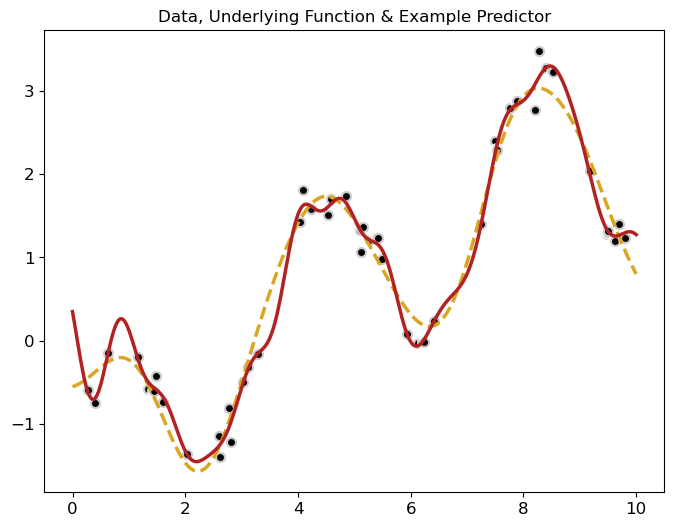

In [12]:
# Generate training data
generator = setup.DataGenerator(r=radius_gen, noise=sigma)
x_train, y_train = generator.get_data('TRAIN', N_train)
x_test, y_test = generator.get_data('TEST', N_test)

# Demonstrate use of basis
centres = np.linspace(generator.x_min, generator.x_max, N_train - 1)
radius_model = radius_gen * 0.5  # Example model uses basis functions that are too narrow
RBF = setup.RBFGenerator(centres, radius_model, bias=True)
PHI_train = RBF.evaluate(x_train)
PHI_test = RBF.evaluate(x_test)

# Find quick fit for fixed guess for alpha and known s2
alph = 1e-3
w_pls = np.linalg.inv(PHI_train.T @ PHI_train + alph * np.eye(RBF.M)) @ PHI_train.T @ y_train
fy_test = PHI_test @ w_pls

# Show the training data and generating function, plus our mean fit
setup.plot_regression(x_train, y_train, x_test, y_test, fy_test)
plt.title("Data, Underlying Function & Example Predictor");

### Updating the basis object

To use our RBF object with `numpyro`, we need to write a `jax` compatible version of it. To this end, a new `JRBFGenerator` object is defined below. There are two modifications:
1. All calls to `numpy` (`np`) routines are redirected to the `jax` version `jnp`
2. The basis function radius $r$ is no longer an attribute of the class, but a parameter of `evaluate`. This makes it easier to use in the contexts where we are changing $r$

In [14]:
#
# Basis class that is JAX compatible
# Centres are fixed for evaluation, but radius is parameterised
#
class JRBFGenerator(object):

    """Generate Jax-compatible Gaussian RBF basis
    with parameterised radius"""

    def __init__(self, loci, bias=False):
        self.M = len(loci)
        self.centres = loci.reshape((self.M, 1))
        self.is_bias = bias
        if bias:
            self.M += 1

    def evaluate(self, X, radius):
        N = len(X)
        d2 = distance.cdist(X, self.centres, metric="sqeuclidean")
        PHI = jnp.exp(-d2 / (radius ** 2))
        if self.is_bias:
            PHI = jnp.hstack((np.ones((N, 1)), PHI))
        #
        return PHI

## Task 4a
*6 marks overall*

#### Implement the Bayesian Linear Regression Model as a Probabilistic Program (6 marks)

Write a function `model(x, y)`, where $x$ is the data input vector and $y$ the training target vector. You should be able to do this clearly in 10 lines of code (but you can use more if required, or if it makes things clearer).

The function will need to specify the distributions  for each variable (or set of variables, in the case of the weights) using `dist` objects within `numpyro.sample` statements. The final output of the model, for which we have observations `y_train`, will also need an `obs` value setting.

How to specify the observation model and prior over $\mathbf{w}$ should be relatively straightforward. It may be less clear as to what hyper-priors you might use for $\alpha$, $\sigma$ and $r$. You are free to adopt your own choices here. That said, in previous examples we have opted for *uniform* priors over a *logarithmic* scale, so this might also be a reasonable approach.

In [16]:
# This can be defined just the once
JRBF = JRBFGenerator(centres, bias=True)

#### **** YOUR CODE HERE **** ####
def model(x, y):
    # Priors (uniform but narrower)
    log_r = numpyro.sample("log_r", dist.Uniform(jnp.log(0.8), jnp.log(1.2)))  # r ∈ [0.8, 1.2]
    r = jnp.exp(log_r)
    
    log_sigma = numpyro.sample("log_sigma", dist.Uniform(jnp.log(0.1), jnp.log(0.3)))  # σ ∈ [0.1, 0.3]
    sigma = jnp.exp(log_sigma)
    
    log_alpha = numpyro.sample("log_alpha", dist.Uniform(jnp.log(0.0001), jnp.log(0.1)))  # α ∈ [0.0001, 0.1]
    alpha = jnp.exp(log_alpha)
   
    # Basis and weights
    PHI = JRBF.evaluate(x, r)
    w = numpyro.sample("w", dist.Normal(0, jnp.sqrt(1.0 / alpha)).expand([PHI.shape[1]]))
    
    # Likelihood
    mean = jnp.dot(PHI, w)
    numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

## Task 4b

**This task is optional, and there are no marks!**

It is nevertheless a useful exercise, but it requires installing non-*Python* executable code, so may be skipped.

### Visualise your model structure

In the below cell, render your above model in the standard "probabilistic graphical model" (PGM) format using `numpyro`'s built-in functionality. This is a handy way of verifying that your model is correctly defined, makes sense, and is structured how you think it is.

### Dependencies

See: https://num.pyro.ai/en/stable/tutorials/model_rendering.html

Model rendering is straightforward and only requires a single function call, **but** it does require that you have a library called `graphviz` appropriately installed, **both the Python module and the system executables**. This latter requirement may be problematic for some (*e.g.* those using University computers), which is why this exercise is optional.

For the Python library (in your appropriate environment of course), on all platforms:

```pip install graphviz```

For the executables, on Linux (Debian-based):

```sudo apt install graphviz```

For Windows and Mac, see: https://graphviz.org/download/

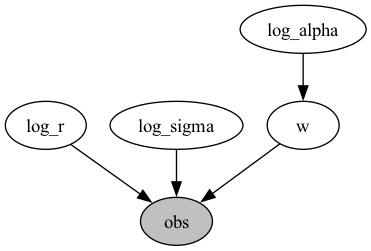

In [18]:
#### **** YOUR CODE HERE **** ####
import numpyro

numpyro.render_model(model, model_args=(x_train, y_train), filename="model.png", render_params=True)

from IPython.display import Image
Image(filename="model.png")


## Task 4c
*3 marks overall*

#### Run the HMC Sampler (2 marks)

Using the "No U-Turn Sampler" (NUTS) Kernel, run MCMC on your model for the training set. It is suggested, but not critical, that you use 500 "warm up" iterations and then obtain 1,000 actual samples. This may take around 10 seconds to run.

The code to do this is fairly straightforward, just a few lines, although you will have to remember to pass in an appropriate random number generator key.

#### Print out the MCMC Summary (1 mark)

Print out a summary of the inference using the built-in functionality of the `MCMC` class. If all is well, you should see that there are zero "divergences" and that `r_hat` is 1.00 (or very, very close) for all variables.

You may notice though that the number of effective samples `n_eff` is considerably lower for the more "indirect" quantities, $\alpha$ and $r$.

In [20]:
#### **** YOUR CODE HERE **** ####
#sample
num_warmup = 500
num_samples = 1000

kernel = NUTS(model) #NUTS kernel
mcmc = MCMC(kernel, num_warmup = 500, num_samples=1000) #MCMC sampler
#random key generation
rng_key = jax.random.key(0)
mcmc.run(rng_key, x=x_train, y=y_train.squeeze())

# Print the summary of results
mcmc.print_summary()


sample: 100%|█| 1500/1500 [00:28<00:00, 52.18it/s, 1023 steps of size 4.49e-03. 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  log_alpha     -2.48      0.18     -2.42     -2.71     -2.30    464.30      1.00
      log_r      0.13      0.05      0.14      0.07      0.18    774.57      1.00
  log_sigma     -1.71      0.12     -1.71     -1.88     -1.50    707.81      1.00
       w[0]      1.26      2.26      1.18     -2.18      5.22    962.74      1.00
       w[1]     -1.93      2.52     -1.87     -6.28      1.99   1048.29      1.00
       w[2]     -0.91      3.01     -0.99     -5.45      4.52   1271.53      1.00
       w[3]     -0.04      3.17     -0.06     -5.29      4.85   1663.77      1.00
       w[4]      0.45      2.90      0.49     -4.25      5.19   1314.31      1.00
       w[5]      0.68      3.08      0.73     -4.81      4.89   1300.87      1.00
       w[6]      0.46      2.96      0.44     -4.00      5.54   1388.39      1.00
       w[7]      0.12      3.20      0.17     -4.71      5.73   1962.01      1.00
       w[8]    

## Task 4d
*2 marks overall*

#### Tabulate posterior estimates (2 marks)

Given the samples from your MCMC run above, calculate and print a table of posterior mean estimates for $\alpha$, $\sigma$ and $r$, both the log values (as sampled) and the transformed (true) values (*i.e.* 10 to the power of the mean log values). For $\sigma$ and $r$, also include the "true" generative values in the table (as defined in the `# Setup` code cell earlier). It is suggested that you use the `tabulate_neatly` helper function here.

In [22]:
#### **** YOUR CODE HERE **** ####

# Extract samples from MCMC
posterior_samples = mcmc.get_samples()

# Compute means of the log parameters
mean_log_alpha = jnp.mean(posterior_samples['log_alpha'])
mean_log_sigma = jnp.mean(posterior_samples['log_sigma'])
mean_log_r = jnp.mean(posterior_samples['log_r'])

# Transform to actual values
mean_alpha = jnp.exp(mean_log_alpha)
mean_sigma = jnp.exp(mean_log_sigma)
mean_r = jnp.exp(mean_log_r)

# Prepare the table: each row is [parameter name, log mean, true mean, true value (if known)]
table = [
    ["α", float(mean_log_alpha), float(mean_alpha), "-"],
    ["σ", float(mean_log_sigma), float(mean_sigma), sigma],
    ["r", float(mean_log_r), float(mean_r), radius_gen],
]

# Define headers
headers = ["Parameter", "Posterior Mean (log)", "Posterior Mean (true)", "True Value (if known)"]


setup.tabulate_neatly(table, headers=headers, title="Posterior Mean Estimates")

Posterior Mean Estimates

Parameter,Posterior Mean (log),Posterior Mean (true),True Value (if known)
α,-2.47686,0.0840069,-
σ,-1.7053,0.181718,0.2
r,0.131699,1.14077,1.0


## Task 4e
*2 marks overall*

#### Assess the performance of the sampler (2 marks)

Use `arviz` to plot the 'trace' of the samples of all the parameters, which also includes a kernel density estimate (KDE). That should give you four sets of two graphs (`arviz` will superimpose the 50 weight parameters onto single plots if `compact=True`, which is recommended!).

On the left is a KDE of the samples, on the right is the 'trace', which is the value of the samples at each iteration. For the hyper-parameters (logs of $\alpha$, $\sigma$ and $r$), this will give graphs analogous to those manually generated in Task 3b of Coursework 2A.

Evidence that things have gone wrong might be:
- the weight samples (left) do not look approximately Gaussian
- the hyper-parameter distributions (left) are multi-modal or highly skewed
- the traces (right) do not look like random noise, but have "structure" (often seen in conjunction with multi-modal KDE plots, as samples transition between modes)
- divergences appear (left)

Generally, the duller the plots are, the more likely the sampler is to have run well!



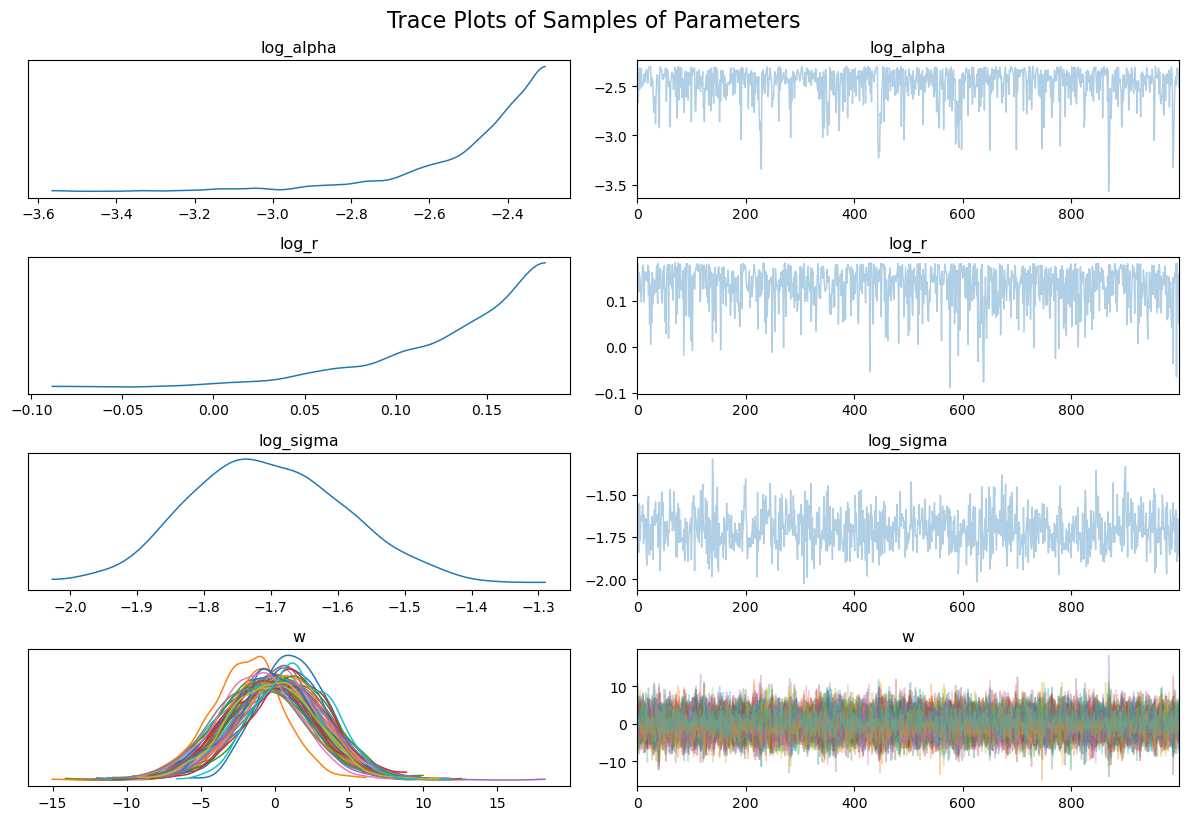

In [24]:
#### **** YOUR CODE HERE **** ####
data=az.from_numpyro(mcmc)
az.plot_trace(data)
plt.tight_layout() 
plt.suptitle('Trace Plots of Samples of Parameters', fontsize=16, y=1.02) 
plt.show()

## Task 4f
*2 marks overall*

Finally, presuming our sampler has operated to our satisfaction, we come to our ultimate objective: to use our samples to make predictions. There are two main ways we could do this:
1. pragmatically, and,
2. correctly!

We'll do both. For this final sub-task, compute the model predictions for the 1,000 test points `x_test` **adopting the two approaches outlined below**. In both cases:
- plot the training data, true function and the predictions (exactly as before) with `plot_regression`
- calculate the RMS test error (use `error_rms` as previously) and either print out or incorporate in the graph title

The "pragmatic" predictor will be much more computationally efficient if deployed, but while both predictors will appear very reasonable, you will probably find that your "correct" predictor exhibits the lower test error (though this is not always guaranteed).

#### Pragmatic: Obtain and evaluate predictions for the test set based on a single set of average parameters (1 mark)

The most computationally efficient predictions might arguably be derived from evaluating the model using one single set of weights (the average of the samples) and the basis functions evaluated with the single posterior mean radius $r$ (giving a single `PHI_test` matrix).

#### Correct: Obtain and evaluate predictions for the test set by averaging over all individual (per-sample) predictions (1 mark)

The "correct" Bayesian thing to do would be to *average every individual prediction*. That is, for each sample, compute the basis matrix `PHI_test` for the respective $r$ and multiply by the corresponding sample of the weights, to obtain a prediction $\mathbf{y}$ *specific to that sample*. Then *average* all the prediction vectors $\mathbf{y}$, one for each sample, to produce an overall single prediction vector. This is clearly more computationally expensive, but also more "strictly Bayesian".


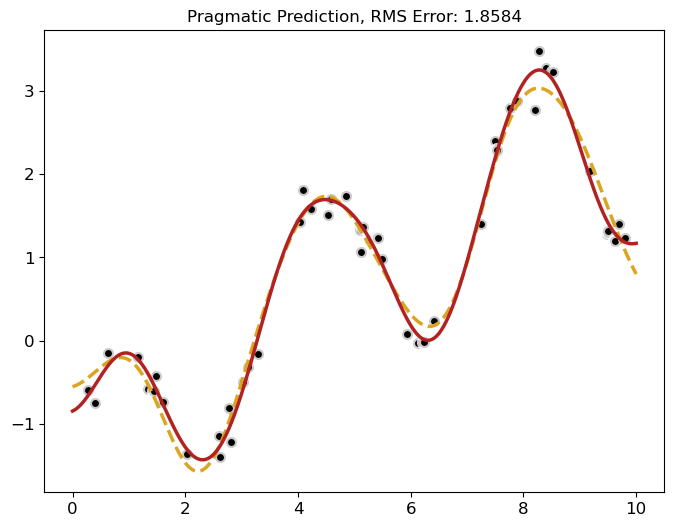

In [26]:
### **** YOUR CODE HERE **** ####
#Pragmatic predictions:
w_mean = np.mean(posterior_samples['w'], axis=0)
r_mean = np.exp(np.mean(posterior_samples['log_r']))  # Transform log_r to r
PHI_test_pragmatic = JRBF.evaluate(x_test, r_mean)
fy_test_pragmatic = PHI_test_pragmatic @ w_mean
rms_pragmatic = setup.error_rms(y_test, fy_test_pragmatic)

# Plot pragmatic predictions
setup.plot_regression(x_train, y_train, x_test, y_test, fy_test_pragmatic)
plt.title(f"Pragmatic Prediction, RMS Error: {rms_pragmatic:.4f}")
plt.show()



Text(0.5, 1.0, 'Correct Bayesian Prediction (RMS Error: 1.856)')

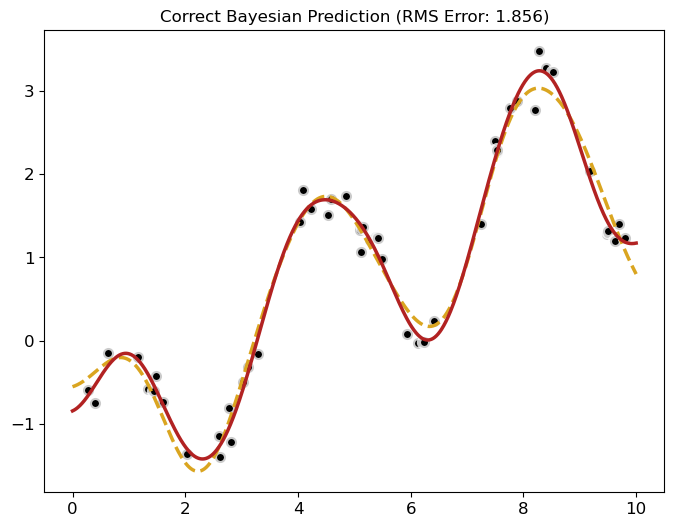

In [27]:
#### **** YOUR CODE HERE **** ####

#Bayesian predictions
# For each sample, compute prediction
y_preds = []
for log_r_sample, w_sample in zip(posterior_samples["log_r"], posterior_samples["w"]):
    r_sample = jnp.exp(log_r_sample)
    RBF_sample = setup.RBFGenerator(centres, r_sample, bias=True)
    PHI_test_sample = RBF_sample.evaluate(x_test)
    y_pred_sample = PHI_test_sample @ w_sample
    y_preds.append(y_pred_sample)

# Average the predictions
y_preds = jnp.stack(y_preds)
y_pred_correct = y_preds.mean(axis=0)

# Plot
setup.plot_regression(x_train, y_train, x_test, y_test, y_pred_correct)
plt.title(f"Correct Bayesian Prediction (RMS Error: {setup.error_rms(y_pred_correct, y_test):.3f})")